# Summary

In this script I fit Linear regression, Elastic net, and LightGBM models to the regression task of predicting production based on monthly rainfall totals. I find the best performance from Elastic net regression with an R$^2$ value of 0.652417, an RMSE of 1115.5 kg and an MAE of 890.7 kg. For comparison, the median production value is 3664.5 kg.

# Libraries

In [2]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from numpy.random import Generator
from numpy.random import SFC64
import numpy as np
import warnings

import lightgbm as lgb
import optuna
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform
from scipy.stats import uniform
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

import constants_helper as c
from function_helper import correlations

# Define Constants

In [3]:
warnings.filterwarnings('ignore')

SEED = 1337
FOLDS = 10
N_SAMPLES = 500

GENERATE_NEW_DATA = False
SAVE_DATA = False
SAVE_MODEL = False

SIM_DATA_PATH = 'data/simulated_data_rainfall.parquet'
MODEL_PATH = 'data/elas_regression_model.joblib'

sns.set_theme()

# Define Functions

In [4]:
# use a better rng than the default numpy rng
rng = Generator(SFC64())

def simulate_data(df, n_samples):
    """
    Return simulated observations based on the means and covariances of the inputted dataframe
    """
    sim = pd.DataFrame(data=rng.multivariate_normal(df.mean(), df.cov(), n_samples), columns=df.columns)
    return sim

In [37]:
def kfold_model(model, X, y):
    models = []
    oof_preds = []
    fi = []
    scores = []
    
    kf = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
    for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
        print(f'{"#"*12} Training FOLD {fold+1} {"#"*12}')
        
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
        
        sca = StandardScaler()
        X_train = sca.fit_transform(X_train)
        X_val = sca.transform(X_val)
        
        X_train = pd.DataFrame(data=X_train, columns=X.columns)
        X_val = pd.DataFrame(data=X_val, columns=X.columns)
        
        model.fit(X_train, y_train)
        
        val_preds = model.predict(X_val)
        idx_pred_target = np.vstack([val_idx, val_preds, y_val]).T
        oof_preds.append(idx_pred_target)
        
        fi.append(dict(zip(model.feature_names_in_, model.coef_)))

        scores.append(mean_squared_error(y_val, val_preds))
        
        models.append(model)
    
    oof_preds = pd.DataFrame(data=np.concatenate(oof_preds), columns=['data_ind', 'preds', 'y_true'])
    oof_preds['data_ind'] = oof_preds['data_ind'].astype('int32')
    oof_preds['y_true'] = oof_preds['y_true'].astype('float32')
    
    return models, oof_preds, fi, scores

In [6]:
def kfold_lgbm(X, y, params, early_stopping_rounds=300, verbose=100, shuffle=True):
    models = []
    oof_preds = []
    fi = []
    
    kf = KFold(n_splits=FOLDS, shuffle=shuffle, random_state=SEED)
    for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
        print(f'{"#"*12} Training FOLD {fold+1} {"#"*12}')
        
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
        eval_set = [(X_val, y_val)]
        
        lgbm = lgb.LGBMRegressor(**params)
        lgbm.fit(X_train, y_train, eval_set=eval_set,
                 early_stopping_rounds=early_stopping_rounds,
                 verbose=verbose)
        
        val_preds = lgbm.predict(X_val)

        idx_pred_target = np.vstack([val_idx, val_preds, y_val]).T
        oof_preds.append(idx_pred_target)

        fi.append(dict(zip(lgbm.feature_name_, lgbm.feature_importances_)))

        models.append(lgbm)
        
    
    oof_preds = pd.DataFrame(data=np.concatenate(oof_preds), columns=['data_ind', 'preds', 'y_true'])
    oof_preds['data_ind'] = oof_preds['data_ind'].astype('int32')
    oof_preds['y_true'] = oof_preds['y_true'].astype('float32')

    return models, oof_preds, fi

In [7]:
def feature_importances_plot(fi, xlabel='Features', ylabel='Magnitude of Importance',
                             Title='Avg Feature Importance and SEM', color_palette='flare_r'):
    """
    Given a feature importance dataframe, plot the mean feature importances in ascending order
    with standard errors on the means.
    """
    
    plt.figure(dpi=200)
    sns.barplot(x=fi.index[np.argsort(fi['mean'])],
                y=fi['mean'][np.argsort(fi['mean'])],
                yerr=fi['sem'][np.argsort(fi['mean'])],
                color=fi['mean'][np.argsort(fi['mean'])],
                palette=sns.color_palette(color_palette, len(fi)))
    plt.xticks(rotation=90)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(Title)

In [8]:
def show_metrics(oof_preds, model_name):
    rmse = np.sqrt(mean_squared_error(oof_preds.y_true, oof_preds.preds))
    mae = mean_absolute_error(oof_preds.y_true, oof_preds.preds)
    median_y = np.median(oof_preds.y_true)
    r2 = r2_score(oof_preds.y_true, oof_preds.preds)
    
    print('RMSE:', rmse)
    print('MAE:', mae)
    print('median y:', median_y)
    print('R2:', r2)
    
    metrics = pd.DataFrame(data=[rmse, mae, median_y, r2],
                           columns=[model_name],
                           index=['rmse', 'mae', 'median_y', 'r2'])
    
    return metrics

In [9]:
def process_fi(fi):
    fi_ = pd.DataFrame(data=fi).transpose()
    fi_mean = pd.DataFrame(fi_.mean(axis=1), columns=['mean'])
    fi_sem = pd.DataFrame(fi_.sem(axis=1), columns=['sem'])
    fi_ = pd.merge(fi_mean, fi_sem, right_index=True, left_index=True)
    
    return fi_

# Load the Data

If generating new simulated data, generate it here, otherwise load data that was previously generated.

In [10]:
# load the real data
df = pd.read_parquet('data/rain_tots_plants_v2.parquet')

# create a profit target
df = df.drop(['year', 'tot_plants', 'prod_per_plant_kg', 'tot_rain_mm', 'dec_rain_mm'], axis=1)
df['profit'] = False
df.loc[df.tot_prod_kg > c.c.profit_thresh_kg, 'profit'] = True


if GENERATE_NEW_DATA is True:
    simf = simulate_data(df.drop(['profit'], axis=1), N_SAMPLES)
    sf = pd.concat([df.drop(['profit'], axis=1), simf], ignore_index=True)
    
    sns.histplot(data=sf, x='tot_prod_kg', label='before removing neg', alpha=0.3)
    
    # About 4% of the simulated production values and 4% of monthly rainfall totals are negative,
    # but we can't have negative rainfall or production, so replace any negative values with 0.
    print('frac of total production < 0:', sum(sf.tot_prod_kg < 0)/ len(sf))
    print('frac of monthly rainfall < 0:', ((sf.drop(['tot_prod_kg'], axis=1) < 0)).sum().sum() / (((sf.drop(['tot_prod_kg'], axis=1) < 0)).sum().sum() + ((sf.drop(['tot_prod_kg'], axis=1) > 0)).sum().sum()))
    stack = sf.stack()
    stack[stack < 0] = 0
    sf = stack.unstack()
    
    sns.histplot(data=sf, x='tot_prod_kg', label='after removing neg', alpha=0.5, zorder=-1)
    plt.legend()
    
    # Create a boolean feature that is True if the total production is greater than
    # the profit threshold and false otherwise. This will be our target variable for classification.
    sf['profit'] = False
    sf.loc[sf.tot_prod_kg > c.c.profit_thresh_kg, 'profit'] = True
    
    sf['tot_prod_kg'] = sf['tot_prod_kg'].astype('float32')
    sf.loc[:, sf.columns[1:-1]] = sf.loc[:, sf.columns[1:-1]].astype('int16')
    
else: 
    sf = pd.read_parquet(SIM_DATA_PATH)
    sf = sf.drop('dec_rain_mm', axis=1)

As a sanity check, let's look at the correlations of all features with respect to production on real and simulated data.

In [11]:
correlations(df) 

,pearson_corr,pval,is_significant
profit,0.848841,2.195597e-08,1.0
may_rain_mm,0.605169,4.022167e-04,1.0
jul_rain_mm,0.274594,7.874113e-02,0.0
jun_rain_mm,0.204311,2.091571e-01,0.0
jan_rain_mm,0.010792,6.861937e-01,0.0
sep_rain_mm,-0.022414,6.371494e-01,0.0
feb_rain_mm,-0.058345,7.179630e-01,0.0
nov_rain_mm,-0.070428,6.134847e-01,0.0
mar_rain_mm,-0.173568,2.302833e-01,0.0
apr_rain_mm,-0.313591,9.615041e-03,1.0


In [12]:
correlations(sf)

,pearson_corr,pval,is_significant
profit,0.810582,3.656414e-09,1.0
may_rain_mm,0.641719,1.485689e-04,1.0
jul_rain_mm,0.234910,1.785177e-01,0.0
jun_rain_mm,0.200675,3.805481e-01,0.0
sep_rain_mm,-0.009228,6.971288e-01,0.0
jan_rain_mm,-0.013361,9.742818e-01,0.0
feb_rain_mm,-0.033588,7.108693e-01,0.0
nov_rain_mm,-0.108282,4.671102e-01,0.0
mar_rain_mm,-0.221278,1.257526e-01,0.0
apr_rain_mm,-0.365743,5.338928e-03,1.0


In [13]:
print('Diff between real and simulated data correlations:')
correlations(df).pearson_corr - correlations(sf).pearson_corr

Diff between real and simulated data correlations:


apr_rain_mm    0.052152
aug_rain_mm   -0.049154
feb_rain_mm   -0.024758
jan_rain_mm    0.024153
jul_rain_mm    0.039684
jun_rain_mm    0.003636
mar_rain_mm    0.047710
may_rain_mm   -0.036549
nov_rain_mm    0.037854
oct_rain_mm    0.023001
profit         0.038259
sep_rain_mm   -0.013186
Name: pearson_corr, dtype: float64

The pearson correlation coefficients are similar in each case between real and simulated data. So are the significances of each correlation (pval < 0.05). 

May rainfall totals are the only feature that has a significant positive correlation with production, and October, August, and April are significantly anti-correlated, though the signal is weak in each case. Based on this, I expect May and possibly October to be important features for classification of whether a year will be profitable.

# Feature Correlations

I also want to watch out for features that correlate strongly with each other because models like logistic regression and SVM can run into problems when multiple features are highly correlated with each other. Gradient boosted trees, on the other hand will not have this problem. Let's look for features that have correlation coefficients greater than 0.4.

In [14]:
sf.corr()[sf.corr() > 0.4]

,tot_prod_kg,jan_rain_mm,feb_rain_mm,mar_rain_mm,apr_rain_mm,may_rain_mm,jun_rain_mm,jul_rain_mm,aug_rain_mm,sep_rain_mm,oct_rain_mm,nov_rain_mm,profit
tot_prod_kg,1.000000,NaN,NaN,NaN,NaN,0.641719,NaN,NaN,NaN,NaN,NaN,NaN,0.810582
jan_rain_mm,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
feb_rain_mm,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mar_rain_mm,NaN,NaN,NaN,1.000000,0.470323,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
apr_rain_mm,NaN,NaN,NaN,0.470323,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
may_rain_mm,0.641719,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.516099
jun_rain_mm,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.745911,NaN,NaN,NaN,NaN,NaN
jul_rain_mm,NaN,NaN,NaN,NaN,NaN,NaN,0.745911,1.000000,NaN,NaN,NaN,NaN,NaN
aug_rain_mm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
sep_rain_mm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN


March and April are nearly 50% correlated, and June and July are nearly 75% correlated. There are a few ways one could handle this, but I'm choosing to create new features that combine these pairs by addition. In other words, the new "mar_apr_combined" feature will be mar_rain_mm + apr_rain_mm, and the same for June and July. I then remove the old features.

In [15]:
sf['mar_apr_combined'] = sf['mar_rain_mm'] + sf['apr_rain_mm']
sf['jun_jul_combined'] = sf['jun_rain_mm'] + sf['jul_rain_mm']

In [16]:
X = sf.drop(['tot_prod_kg', 'profit', 'mar_rain_mm', 'apr_rain_mm', 'jun_rain_mm', 'jul_rain_mm'], axis=1)
y = sf.tot_prod_kg

We now have 9 features instead of 11.

In [17]:
print('shape of X:', X.shape)
print('shape of y:', y.shape)

shape of X: (515, 9)
shape of y: (515,)


# Linear Regression

In [38]:
lr = LinearRegression()

models_lr, oof_preds_lr, fi_lr, scores_lr = kfold_model(lr, X, y)

############ Training FOLD 1 ############
############ Training FOLD 2 ############
############ Training FOLD 3 ############
############ Training FOLD 4 ############
############ Training FOLD 5 ############
############ Training FOLD 6 ############
############ Training FOLD 7 ############
############ Training FOLD 8 ############
############ Training FOLD 9 ############
############ Training FOLD 10 ############


In [39]:
fi_lr = process_fi(fi_lr)

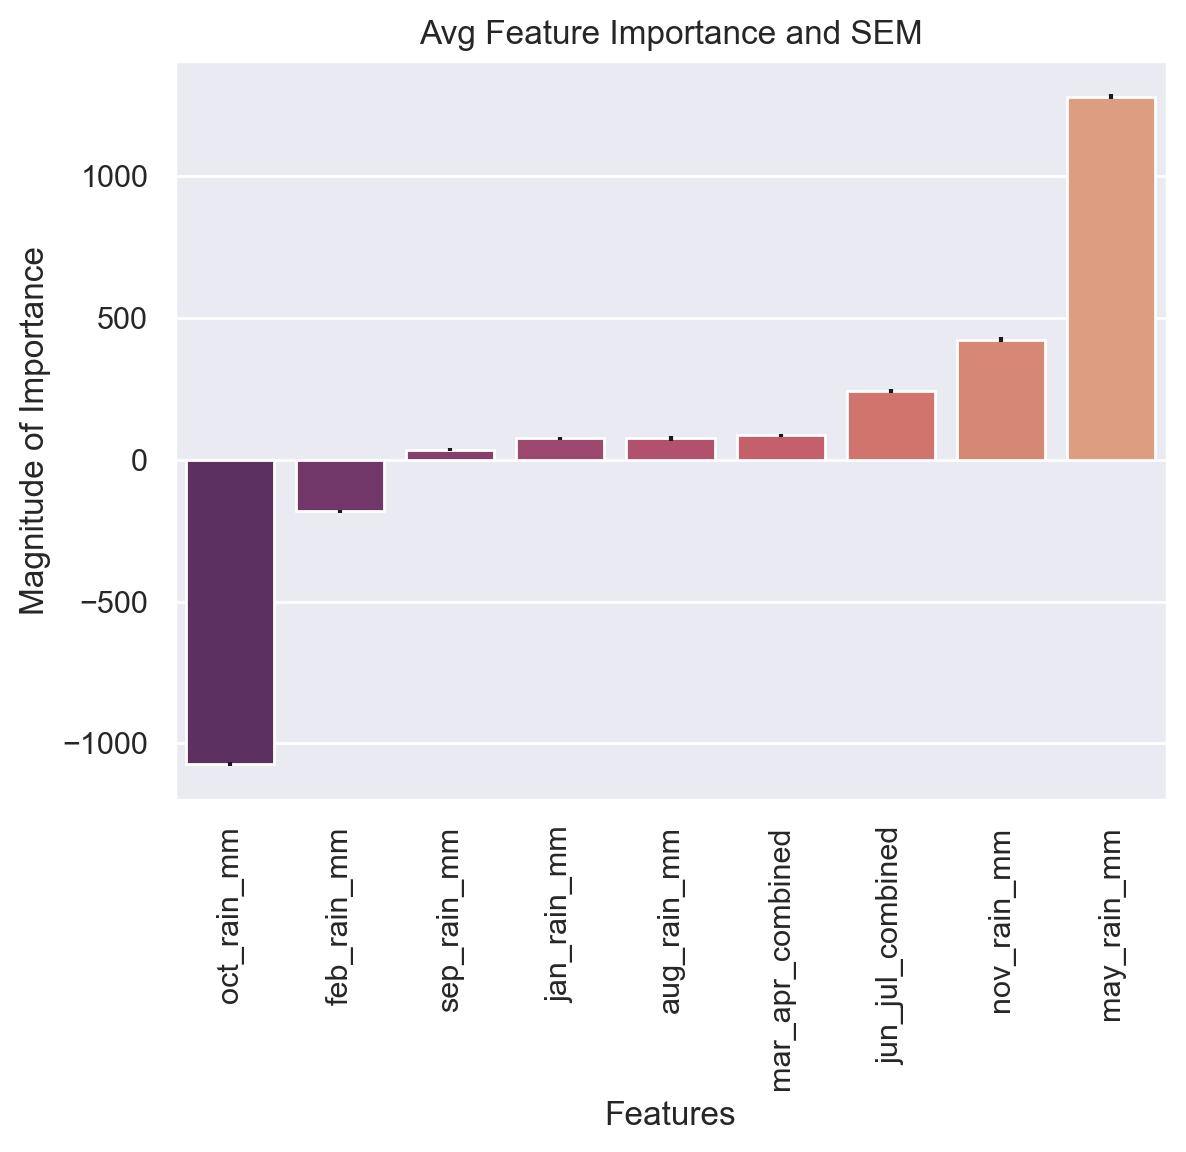

In [40]:
feature_importances_plot(fi_lr)

In [41]:
oof_preds_lr

,data_ind,preds,y_true
0,13,3888.633547,5340.000000
1,25,7471.091036,8420.602539
2,35,3118.282205,3768.430908
3,45,3899.590734,2548.221436
4,46,5964.881592,4209.190430
...,...,...,...
510,502,1173.563569,1307.285889
511,504,864.231863,744.236877
512,507,5280.084155,6145.133789
513,508,4731.593193,5776.019531


In [47]:
np.sqrt(np.mean(scores_lr))

1115.7357143107552

In [48]:
metrics_lr = show_metrics(oof_preds_lr, model_name='lr')

RMSE: 1115.5765578964993
MAE: 890.8668152812362
median y: 3664.5198
R2: 0.6523761579266063


In [49]:
metrics_lr

,lr
rmse,1115.576558
mae,890.866815
median_y,3664.519775
r2,0.652376


# Results Linear Regression

K-fold cross validation with a simple linear regression model fit to simulated data shows an $R^2$ of 0.65, meaning 65% of the variance in production is explained by this model. The RMSE and MAE are a third or less than the median production value, which is a large reduction in uncertainty over my models from last year. This is due to the fact that we have a lot more data to work with when we simulate data instead of being restricted to 15 data points. This will be our baseline model and I'll see if we can get better performance with other models. I will start with LightGBM and I will perform hyperparameter optimization with Optuna.

In [50]:
def objective(trial):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rng.integers(100, 10_000))
    dtrain = lgb.Dataset(X_train, label=y_train)
    
    param = {
        'objective': 'regression',
        'metric': 'mse',
        'n_estimators': 1000,
        'verbose': -1,
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006, 0.008, 0.01, 0.014, 0.017, 0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [10, 20, 100]),
        'num_leaves' : trial.suggest_int('num_leaves', 2, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 50),
    }
    
    gbm = lgb.train(param, dtrain)
    preds = gbm.predict(X_test)
    
    mse_score = mean_squared_error(y_test, preds)
    
    return mse_score

In [27]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=200)

[I 2023-03-07 12:43:03,312] A new study created in memory with name: no-name-f34e8ffd-36a8-423d-8360-c67f6617fb6d
[I 2023-03-07 12:43:03,536] Trial 0 finished with value: 1407696.688828968 and parameters: {'reg_alpha': 7.291621827374084, 'reg_lambda': 0.24477138553667005, 'learning_rate': 0.014, 'max_depth': 100, 'num_leaves': 5, 'min_child_samples': 17}. Best is trial 0 with value: 1407696.688828968.
[I 2023-03-07 12:43:03,675] Trial 1 finished with value: 1524577.301314293 and parameters: {'reg_alpha': 1.2513576249490277, 'reg_lambda': 0.002637561111862704, 'learning_rate': 0.014, 'max_depth': 100, 'num_leaves': 2, 'min_child_samples': 19}. Best is trial 0 with value: 1407696.688828968.
[I 2023-03-07 12:43:03,936] Trial 2 finished with value: 1741918.1914631722 and parameters: {'reg_alpha': 0.48207325043355226, 'reg_lambda': 1.036777622395103, 'learning_rate': 0.017, 'max_depth': 10, 'num_leaves': 7, 'min_child_samples': 29}. Best is trial 0 with value: 1407696.688828968.
[I 2023-03-

In [51]:
print('best rmse:', np.sqrt(study.best_trial.value))

best rmse: 1063.3780815836183


In [52]:
study.best_params

{'reg_alpha': 0.012466958404923028,
 'reg_lambda': 0.017560950215481264,
 'learning_rate': 0.008,
 'max_depth': 10,
 'num_leaves': 3,
 'min_child_samples': 34}

In [58]:
params = {
    'objective': 'regression',
    'metric': 'mse',
    'n_estimators': 2000,
    'learning_rate': study.best_params['learning_rate'],
    'max_depth': study.best_params['max_depth'],
    'num_leaves': study.best_params['num_leaves'],
    'min_child_samples': study.best_params['min_child_samples'],
    'reg_alpha': study.best_params['reg_alpha'],
    'reg_lambda': study.best_params['reg_lambda']
}

In [ ]:
models_lgbm, oof_preds_lgbm, fi_lgbm = kfold_lgbm(X, y, params, early_stopping_rounds=50, verbose=100, shuffle=True)

In [60]:
metrics_lgbm = show_metrics(oof_preds_lgbm, model_name='lgbm')

RMSE: 1215.4420253291814
MAE: 979.4753573481175
median y: 3664.5198
R2: 0.5873524290909662


In [61]:
metrics_lgbm

,lgbm
rmse,1215.442025
mae,979.475357
median_y,3664.519775
r2,0.587352


# Results LightGBM

The LightGBM model performs worse on all our metrics than the linear regression model without regularization, but the feature importances are similar as we can see below.

In [62]:
fi_lgbm = process_fi(fi_lgbm)

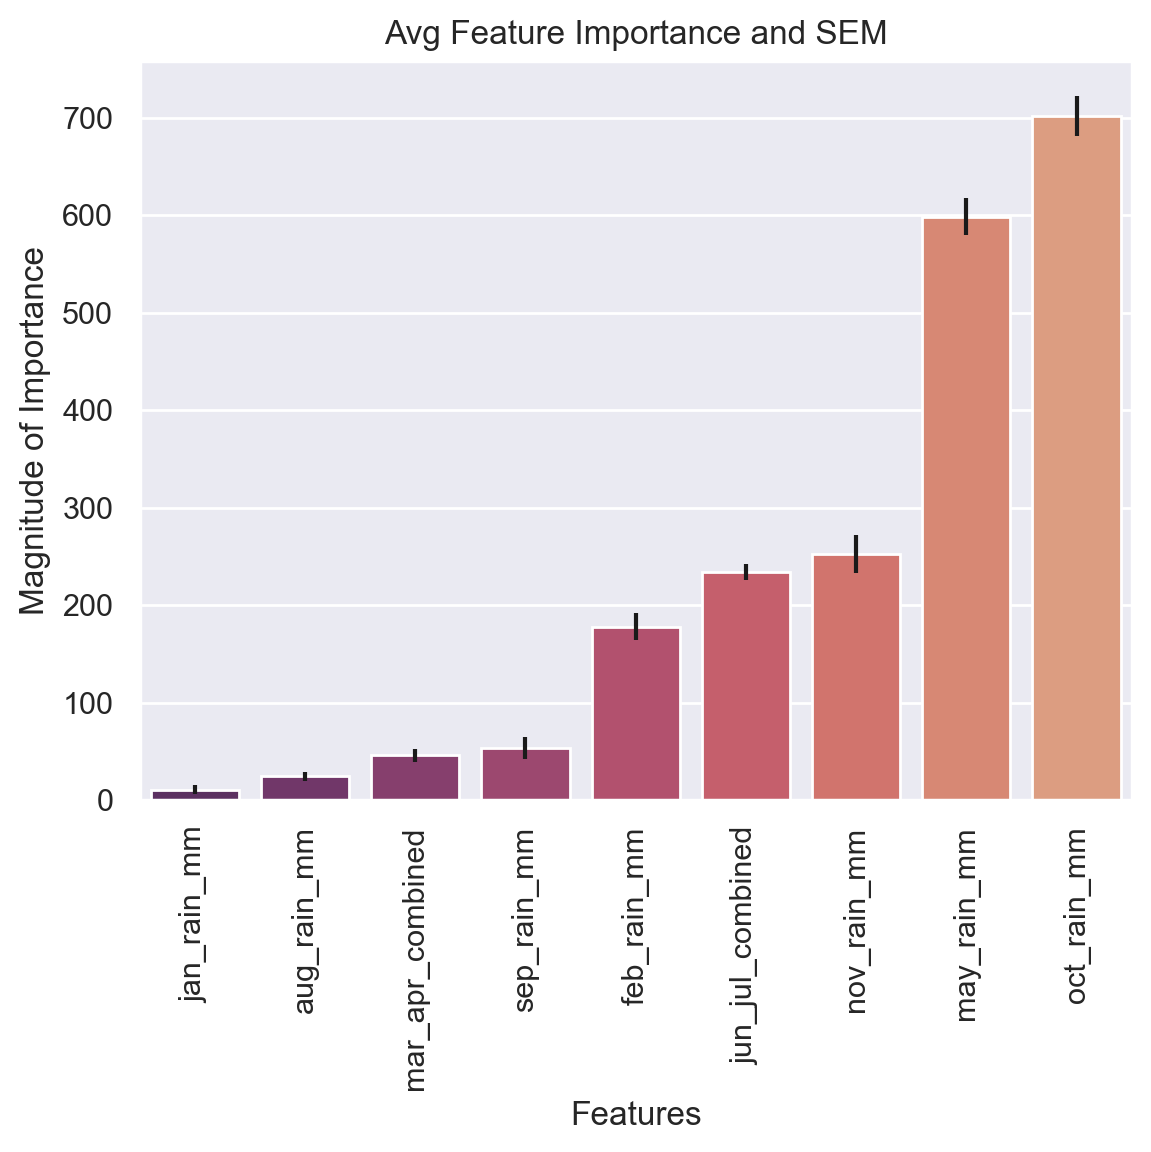

In [63]:
feature_importances_plot(fi_lgbm)

# Elastic Net Model

In [64]:
# help(ElasticNet)

In [65]:
params = {
    'elas__alpha': loguniform(1e-5, 1e2),
    'elas__l1_ratio': uniform(0, 1)
}

pipe_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('elas', ElasticNet(max_iter=10_000))
])

elas = RandomizedSearchCV(pipe_lr,
                        param_distributions=params,
                        n_iter=1_000,
                        scoring='neg_mean_squared_error',
                        verbose=1,
                        random_state=SEED,
                        cv=FOLDS)

In [66]:
elas.fit(X, y)

Fitting 10 folds for each of 1000 candidates, totalling 10000 fits


RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('elas',
                                              ElasticNet(max_iter=10000))]),
                   n_iter=1000,
                   param_distributions={'elas__alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000227651D6550>,
                                        'elas__l1_ratio': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000022763C04ED0>},
                   random_state=1337, scoring='neg_mean_squared_error',
                   verbose=1)

# Best Parameters, Randomized Search, Elastic Net

In [67]:
best_params_elas = elas.best_params_
best_params_elas

{'elas__alpha': 0.009125128891602862, 'elas__l1_ratio': 0.25190402856513405}

In [69]:
print('best RMSE:', np.sqrt(np.abs(elas.best_score_)))

best RMSE: 1120.9219298603982


In [70]:
elas = ElasticNet(max_iter=10_000, alpha=best_params_elas['elas__alpha'], l1_ratio=best_params_elas['elas__l1_ratio'])

In [71]:
models_elas, oof_preds_elas, fi_elas, scores_elas = kfold_model(elas, X, y)

############ Training FOLD 1 ############
############ Training FOLD 2 ############
############ Training FOLD 3 ############
############ Training FOLD 4 ############
############ Training FOLD 5 ############
############ Training FOLD 6 ############
############ Training FOLD 7 ############
############ Training FOLD 8 ############
############ Training FOLD 9 ############
############ Training FOLD 10 ############


In [72]:
metrics_elas = show_metrics(oof_preds_elas, model_name='elas')

RMSE: 1115.510655168059
MAE: 890.6643652980162
median y: 3664.5198
R2: 0.652417228497363


In [73]:
metrics_elas

,elas
rmse,1115.510655
mae,890.664365
median_y,3664.519775
r2,0.652417


In [74]:
fi_elas = process_fi(fi_elas)

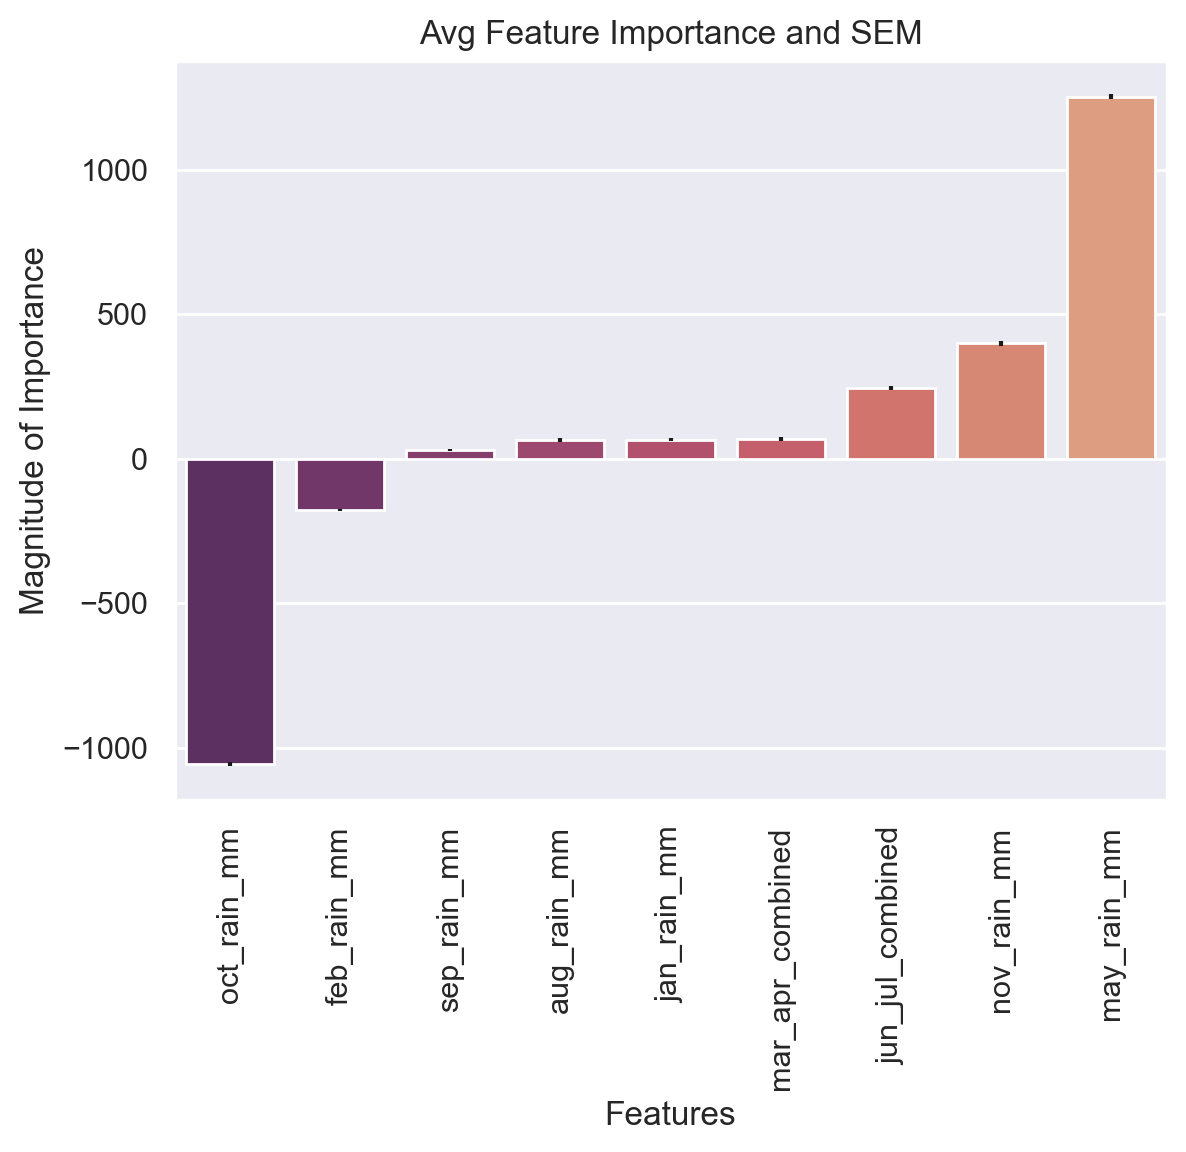

In [77]:
feature_importances_plot(fi_elas)

In [78]:
metrics = metrics_lr.copy()

In [79]:
metrics['lgbm'] = metrics_lgbm

In [80]:
metrics['elas'] = metrics_elas

In [81]:
metrics

,lr,lgbm,elas
rmse,1115.576558,1215.442025,1115.510655
mae,890.866815,979.475357,890.664365
median_y,3664.519775,3664.519775,3664.519775
r2,0.652376,0.587352,0.652417


# Final Comparison

Our performance is slightly better in terms of RMSE and MAE with elastic net regularization than with linear regression without regularization. This is the model I will train on all the data and save for use in the dashboard.

In [82]:
elas_final = ElasticNet(max_iter=10_000, alpha=best_params_elas['elas__alpha'], l1_ratio=best_params_elas['elas__l1_ratio'])

In [83]:
sca = StandardScaler()
X_sca = sca.fit_transform(X)

X_sca = pd.DataFrame(data=X_sca, columns=X.columns)

In [84]:
elas_final.fit(X_sca, y)

ElasticNet(alpha=0.009125128891602862, l1_ratio=0.25190402856513405,
           max_iter=10000)

In [85]:
if SAVE_DATA is True:
    sf.to_parquet(SIM_DATA_PATH)

if SAVE_MODEL is True:
    dump(elas_final, MODEL_PATH)